Usando 15000 muestras del ECG para el análisis (~2 min cálculo)


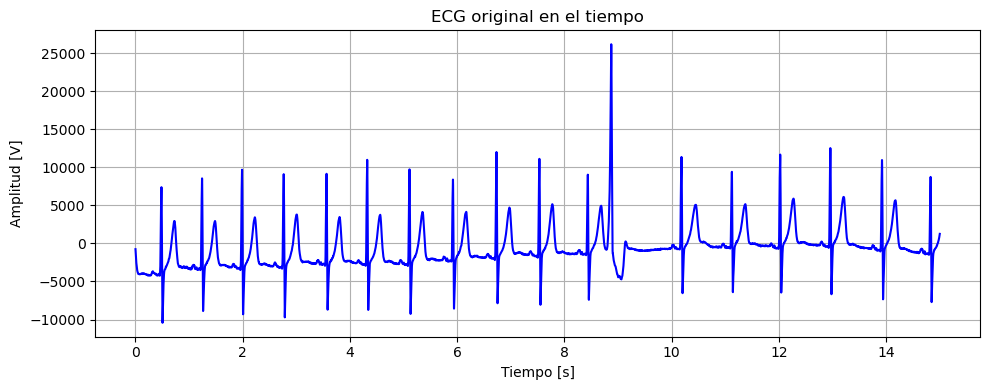

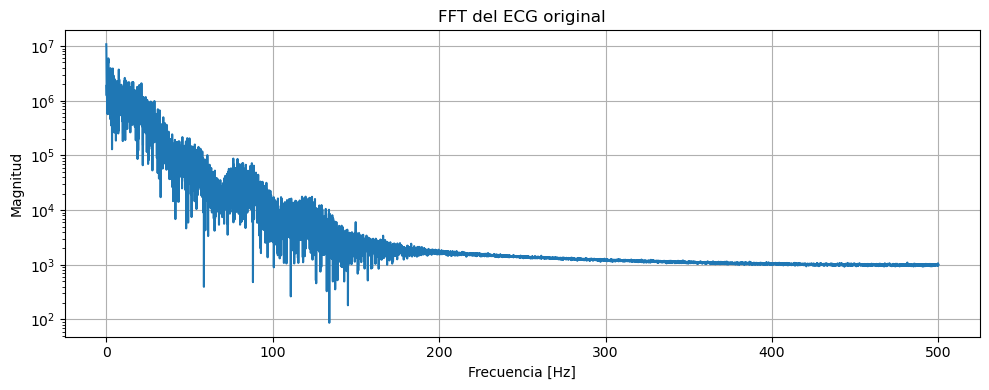

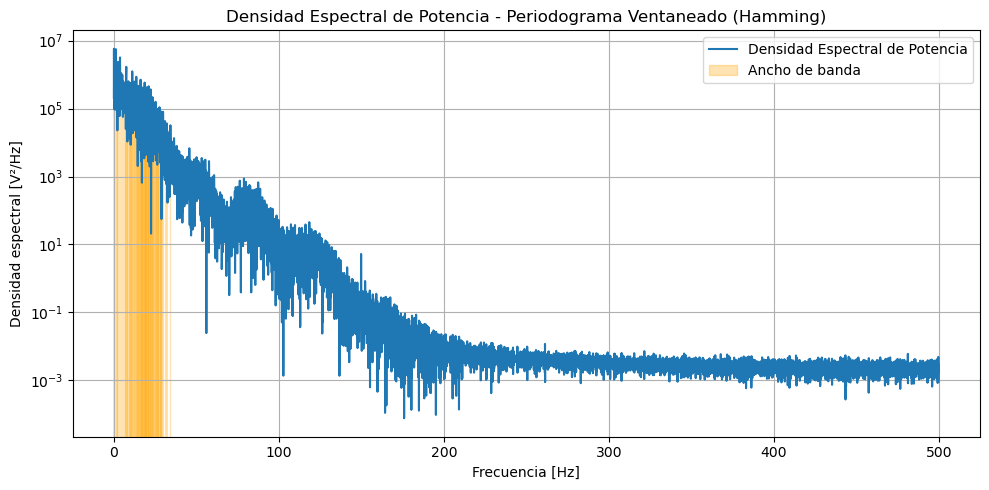

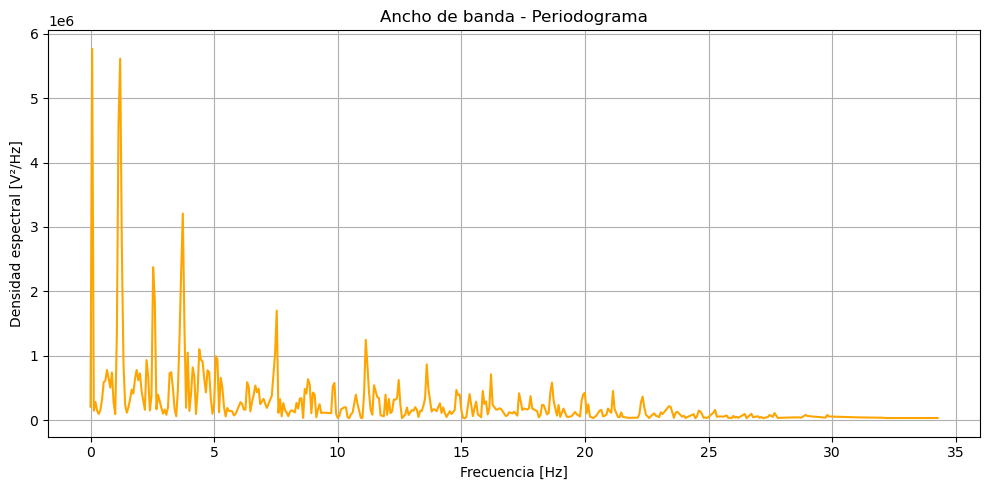

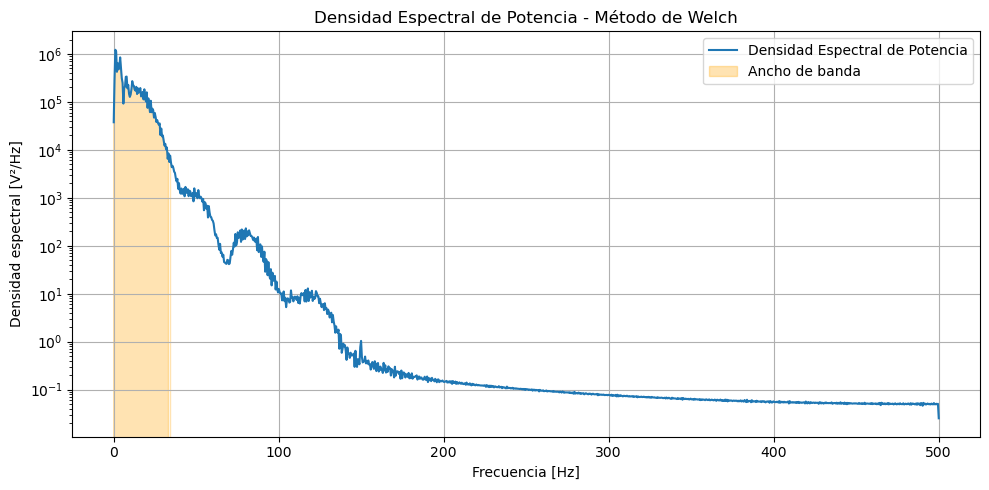

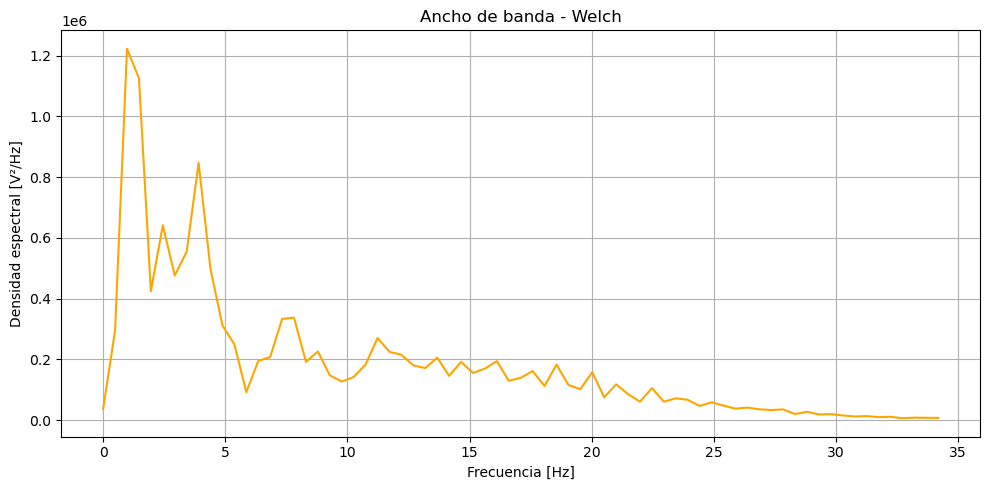

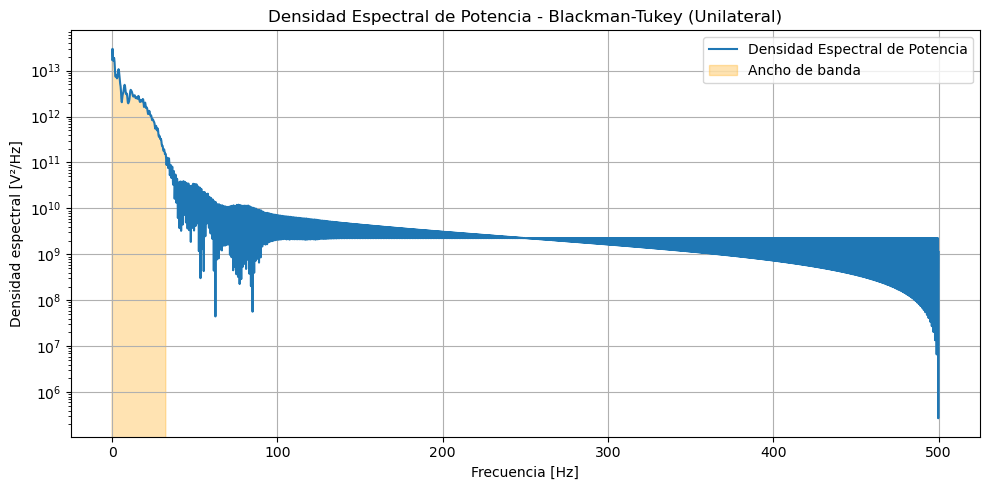

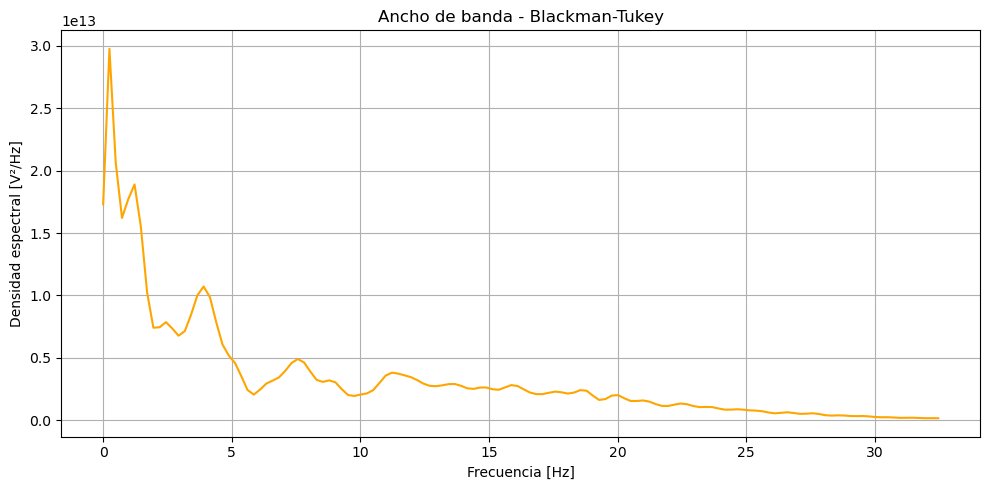

Blackman-Tukey calculado en 1.2 segundos

Resultados del ancho de banda estimado:

           Método  Frecuencia baja [Hz]  Frecuencia alta [Hz]  \
0    Periodograma                   0.0             34.266667   
1           Welch                   0.0             34.179688   
2  Blackman–Tukey                   0.0             32.470703   

   Ancho de banda [Hz]  
0            34.266667  
1            34.179688  
2            32.470703  

 Tabla guardada en 'resultados/ancho_de_banda_Densidad_Espectral_de_Potencia.csv'
 Todos los gráficos guardados en 'resultados/' y mostrados en pantalla


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Densidad Espectral de Potencia del ECG 
Cantidad de muestras ajustada para ~2 minutos de cálculo

- La Densidad Espectral de Potencia (PSD) describe cómo se distribuye la potencia de la señal a través de las frecuencias.
- Periodograma: estimación directa de PSD usando FFT de toda la señal. Es sensible al ruido.
- Welch: divide la señal en segmentos solapados, calcula los periodogramas y los promedia para reducir varianza.
- Blackman-Tukey: calcula la FFT de la autocorrelación limitada de la señal, proporciona una PSD suavizada y estable.
- Ventanas (Hamming, etc.): evitan fugas espectrales al suavizar los bordes de cada segmento.
- Ancho de banda: rango de frecuencias donde la PSD supera un umbral relativo (ej: 1% del máximo).
- FFT de la señal original: permite ver la composición espectral directa sin estimación de densidad.
"""

import numpy as np                       # Para manejo de arrays y cálculos numéricos
import scipy.io as sio                   # Para leer archivos .mat (MATLAB)
import matplotlib.pyplot as plt          # Para generar gráficos
from scipy.signal import periodogram, welch, windows  # Para cálculo de PSD y ventanas
import pandas as pd                      # Para manejar tablas de resultados
import os                                # Para manejo de directorios
import time                              # Para medir tiempo

# ----------------------------
# Cargar archivo .mat
# ----------------------------
mat = sio.loadmat('ECG_TP4.mat')        # Leer archivo MATLAB
ecg_full = np.squeeze(mat['ecg_lead'])  # Extraer la señal ECG de la estructura y eliminar dimensiones extra
fs = 1000  # Hz                         # Frecuencia de muestreo del ECG

# Nota: fs = 1000 Hz es suficiente para capturar la actividad cardíaca típica (hasta 250 Hz)

# ----------------------------
# Ajustar cantidad de muestras para cálculo (~2 minutos)
# ----------------------------
N_samples = 15000                        # Número de muestras a usar
ecg = ecg_full[:N_samples]               # Tomar solo las primeras N_samples
N = len(ecg)                             # Longitud real de la señal usada
print(f"Usando {N} muestras del ECG para el análisis (~2 min cálculo)")

# ----------------------------
# Crear carpeta de resultados si no existe
# ----------------------------
os.makedirs('resultados', exist_ok=True)

# ----------------------------
# Función ancho de banda y rango
# ----------------------------
def bandwidth(f, Pxx, threshold=0.005):
    """
    Calcula el ancho de banda de la señal en función de un umbral relativo.
    
    - Normalizo la PSD para que el valor máximo = 1
    - Selecciono las frecuencias donde la PSD > threshold
    - Esto permite comparar anchos de banda entre distintos métodos
    """
    Pxx_norm = Pxx / np.max(Pxx)
    mask = Pxx_norm > threshold
    if np.any(mask):
        f_bw = f[mask]
        return f_bw[0], f_bw[-1], f_bw[-1] - f_bw[0], mask
    else:
        return 0, 0, 0, mask

# ----------------------------
# Función Blackman-Tukey
# ----------------------------
def per_smooth(x, win=1, M=1024, fs=1000, nfft=4096):
    """
    Implementación del método Blackman-Tukey para estimar la PSD.
    Devuelve el espectro unilateral (solo frecuencias positivas)
    
    Parámetros:
    - x: señal de entrada
    - win: tipo de ventana (1=rectangular, 2=Hamming, 3=Hanning, 4=Bartlett, 5=Blackman)
    - M: número de retardos para autocorrelación
    - fs: frecuencia de muestreo
    - nfft: número de puntos FFT
    - f: vector de frecuencias (0 a fs/2)
    - Pxx: PSD estimada unilateral
    """
    x = np.asarray(x).flatten()
    x = x - np.mean(x)  # Centrar la señal

    # ----------------------------
    # Autocorrelación
    # ----------------------------
    rxx_full = np.correlate(x, x, mode='full')
    mid = len(rxx_full) // 2
    rxx = rxx_full[mid - M + 1 : mid + M]  # Simétrico alrededor de 0

    # ----------------------------
    # Ventana
    # ----------------------------
    window_types = {1: 'boxcar', 2: 'hamming', 3: 'hann', 4: 'bartlett', 5: 'blackman'}
    w = windows.get_window(window_types.get(win, 'boxcar'), len(rxx))
    rxx_win = rxx * w

    # ----------------------------
    # FFT de la autocorrelación suavizada
    # ----------------------------
    Pxx_full = np.abs(np.fft.fft(rxx_win, nfft))
    
    # --- Espectro Unilateral ---
    
    # 1. Calcular el número de puntos hasta Nyquist
    n_unique = nfft // 2 + 1
    
    # 2. Tomar la primera mitad y escalar para PSD Unilateral
    Pxx_uni = Pxx_full[:n_unique]
    
    # 3. Aplicar escalado para "densidad de potencia" (multiplicar por 2, excepto 0 y Nyquist)
    # Blackman-Tukey no siempre usa el factor 1/(fs*N) de forma directa como en periodogram. 
    # Para que sea comparable, se escala la parte unilateral.
    Pxx = Pxx_uni.copy()
    Pxx[1:-1] *= 2 # Multiplicar por 2 los puntos intermedios
    
    # 4. Vector de frecuencias para el espectro unilateral
    f = np.linspace(0, fs / 2, n_unique)

    return f, Pxx

# ----------------------------
# Señal ECG original en el tiempo
# ----------------------------
plt.figure(figsize=(10,4))              
plt.plot(np.arange(N)/fs, ecg, color='blue')
plt.title("ECG original en el tiempo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [V]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/ECG_original_tiempo.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# FFT de la señal ECG original
# ----------------------------
fft_ecg = np.fft.fft(ecg, n=N)
# f_fft y fft_mag ya están en el rango unilateral (0 a fs/2)
f_fft = np.linspace(0, fs/2, N//2)
fft_mag = np.abs(fft_ecg[:N//2])

plt.figure(figsize=(10,4))
plt.semilogy(f_fft, fft_mag)
plt.title("FFT del ECG original")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/FFT_ECG.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# 1) Periodograma ventaneado
# ----------------------------
ventana = windows.hamming(N)
f_per, Pxx_per = periodogram(ecg, fs=fs, window=ventana, nfft=N, scaling='density')
f_low_per, f_high_per, BW_per, mask_per = bandwidth(f_per, Pxx_per)

plt.figure(figsize=(10,5))
plt.semilogy(f_per, Pxx_per, label='Densidad Espectral de Potencia')
plt.fill_between(f_per, Pxx_per, where=mask_per, color='orange', alpha=0.3, label='Ancho de banda')
plt.title("Densidad Espectral de Potencia - Periodograma Ventaneado (Hamming)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [V²/Hz]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_periodograma.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10,5))
plt.plot(f_per[mask_per], Pxx_per[mask_per], color='orange')
plt.title("Ancho de banda - Periodograma")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [V²/Hz]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Densidad_Espectral_de_Potencia_periodograma.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# 2) Welch
# ----------------------------
f_welch, Pxx_welch = welch(ecg, fs=fs, window='hamming', nperseg=2048, noverlap=1024, scaling='density')
f_low_w, f_high_w, BW_w, mask_w = bandwidth(f_welch, Pxx_welch)

plt.figure(figsize=(10,5))
plt.semilogy(f_welch, Pxx_welch, label='Densidad Espectral de Potencia')
plt.fill_between(f_welch, Pxx_welch, where=mask_w, color='orange', alpha=0.3, label='Ancho de banda')
plt.title("Densidad Espectral de Potencia - Método de Welch")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [V²/Hz]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_welch.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10,5))
plt.plot(f_welch[mask_w], Pxx_welch[mask_w], color='orange')
plt.title("Ancho de banda - Welch")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [V²/Hz]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Densidad_Espectral_de_Potencia_welch.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# 3) Blackman-Tukey
# ----------------------------
start_time = time.time()
f_bt, Pxx_bt = per_smooth(ecg, win=2, M=1024, fs=fs, nfft=4096)
f_low_bt, f_high_bt, BW_bt, mask_bt = bandwidth(f_bt, Pxx_bt)

plt.figure(figsize=(10,5))
plt.semilogy(f_bt, Pxx_bt, label='Densidad Espectral de Potencia')
plt.fill_between(f_bt, Pxx_bt, where=mask_bt, color='orange', alpha=0.3, label='Ancho de banda')
plt.title("Densidad Espectral de Potencia - Blackman-Tukey (Unilateral)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [V²/Hz]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_blackman_tukey.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10,5))
plt.plot(f_bt[mask_bt], Pxx_bt[mask_bt], color='orange')
plt.title("Ancho de banda - Blackman-Tukey")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [V²/Hz]")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Densidad_Espectral_de_Potencia_blackman_tukey.png', dpi=300)
plt.show()
plt.close()

end_time = time.time()
print(f"Blackman-Tukey calculado en {end_time - start_time:.1f} segundos")

# ----------------------------
# Tabla de anchos de banda
# ----------------------------
tabla_bw = pd.DataFrame({
    "Método": ["Periodograma", "Welch", "Blackman–Tukey"],
    "Frecuencia baja [Hz]": [f_low_per, f_low_w, f_low_bt],
    "Frecuencia alta [Hz]": [f_high_per, f_high_w, f_high_bt],
    "Ancho de banda [Hz]": [BW_per, BW_w, BW_bt]
})

print("\nResultados del ancho de banda estimado:\n")
print(tabla_bw)
tabla_bw.to_csv('resultados/ancho_de_banda_Densidad_Espectral_de_Potencia.csv', index=False, float_format='%.3f')
print("\n Tabla guardada en 'resultados/ancho_de_banda_Densidad_Espectral_de_Potencia.csv'")
print(" Todos los gráficos guardados en 'resultados/' y mostrados en pantalla")